In [1]:
import IPython.display
import pandas
import np_session

In [5]:
import datetime
import pathlib  
import shutil
import time
import pprint
from typing import Generator, Optional
import IPython.display

import np_session
from np_session import Session, PipelineSession, sessions as get_sessions
from np_tools import get_files_created_between, ssh

problem_sessions = [
    
]

def npexp_sessions(skip_already_checked=True) -> Generator[PipelineSession, None, None]:
    for session in get_sessions('TTN'):
        if any(_ in str(session) for _ in problem_sessions) and skip_already_checked:
            continue
        yield session

sessions: Generator[PipelineSession, None, None] = npexp_sessions()

In [35]:
# session = next(sessions)
# session.get_missing_files()
session = Session('1275082330_669417_20230606')

# session = np_session.Session('1276522234_673694_20230613')
session = np_session.Session('1275082330_669417_20230606')

Cleanup files before transfer

In [36]:
if session.project.parent.name == 'DR':
    for _ in session.npexp_path.glob('*surface-image*'):
        for replace in ('-right', '-left'):
            if replace in _.name:
                _.replace(_.parent / _.name.replace(replace, ''))
for _ in session.npexp_path.glob('*platform*.bak'):
    _.unlink()
for _ in session.npexp_path.glob('*platform*D0*json'):
    _.unlink()

In [37]:
names = session.D1.names + session.D2.names
globs = session.D1.globs + session.D2.globs
paths = session.D1.paths + session.D2.paths
types = session.D1.types + session.D2.types

print(session.npexp_path)
display(df := pandas.DataFrame(({'glob': glob, 'exists': path.name if path else None} for glob, path in zip(globs, paths)), index=names))

\\allen\programs\mindscope\workgroups\np-exp\1275082330_669417_20230606


,glob,exists
ephys_raw_data_probe_A,*_probeABC,1275082330_669417_20230606_probeABC
ephys_raw_data_probe_B,*_probeABC,1275082330_669417_20230606_probeABC
ephys_raw_data_probe_C,*_probeABC,1275082330_669417_20230606_probeABC
ephys_raw_data_probe_D,*_probeDEF,1275082330_669417_20230606_probeDEF
ephys_raw_data_probe_E,*_probeDEF,1275082330_669417_20230606_probeDEF
ephys_raw_data_probe_F,*_probeDEF,1275082330_669417_20230606_probeDEF
synchronization_data,*.sync,1275082330_669417_20230606.sync
behavior_tracking,*.behavior.mp4,1275082330_669417_20230606.behavior.mp4
beh_cam_json,*.behavior.json,1275082330_669417_20230606.behavior.json
eye_tracking,*.eye.mp4,1275082330_669417_20230606.eye.mp4


('A', 'B', 'C', 'D', 'E', 'F')


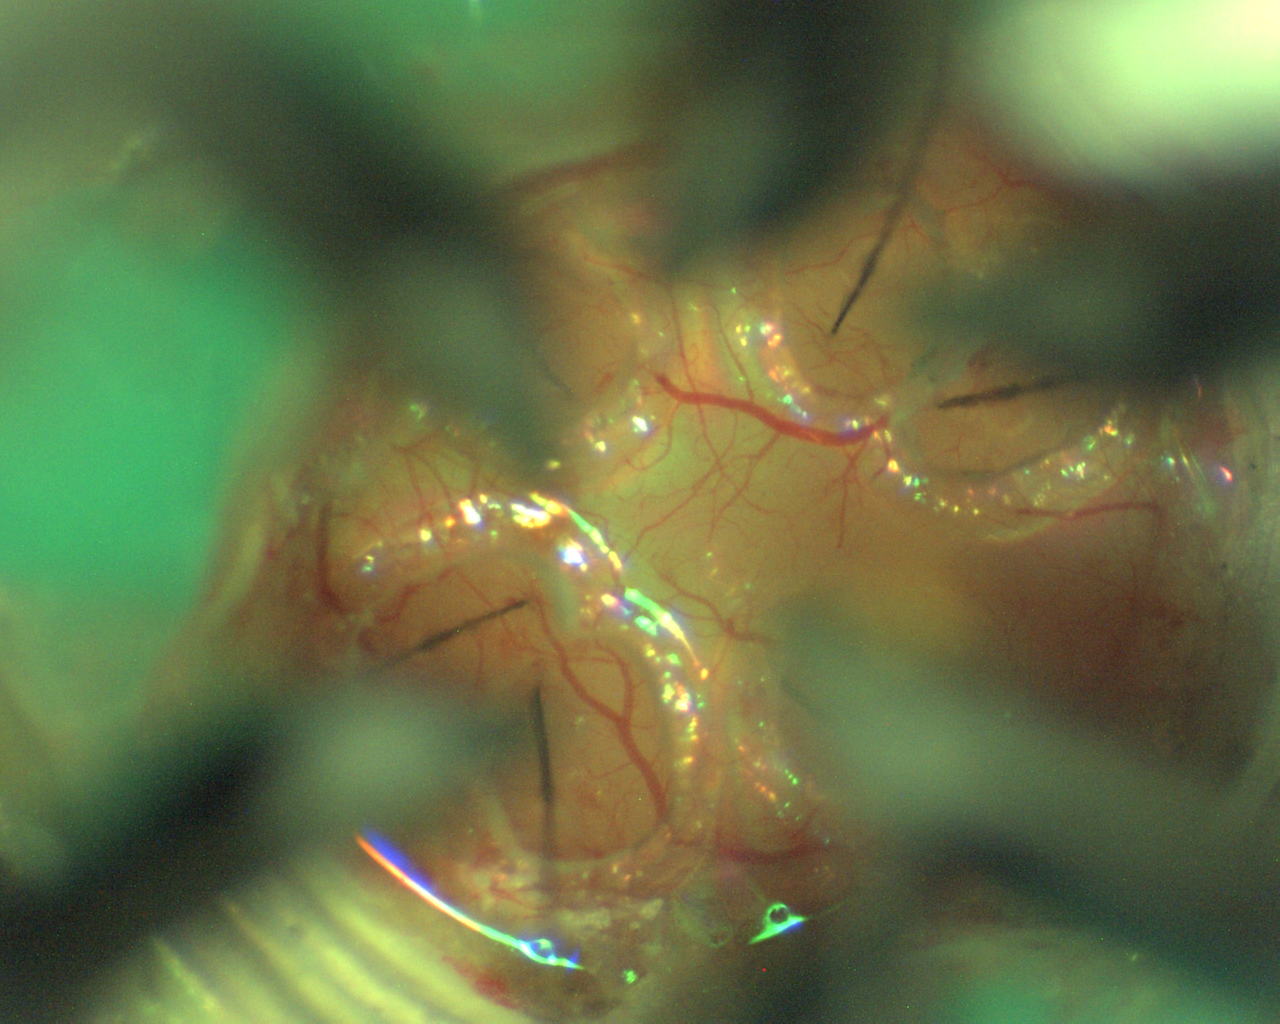

In [38]:
print(session.probes_inserted)
from IPython.display import Image
Image(session.npexp_path / df.loc['post_insertion_surface_image_left']['exists'])

In [39]:
session.platform_json.InsertionNotes

{'ProbeD': {'Notes': 'o', 'FailedToInsert': 0}}

Change the probes inserted here if necessary, but you'll need to go back to
creating the session instance from scratch:

In [40]:
session.probes_inserted = 'ABCDEF'

In [41]:
if not all(paths) or not all(df['exists'].values):
    raise Warning('Some files are missing - continue with upload at your own risk!')
else:
    print('All files exist')

All files exist


In [42]:
for _ in paths:
    if _ and str(session.id) not in _.name:
        print(f'Warning! File name does not contain session id: {_.name}')
else:
    print('All filenames contain session id')


All filenames contain session id


Get D1 & D2 `files` dicts for platform json - the manifests for uploading to LIMS

In [43]:
files = (session.D1.files | session.D2.files)

Remove surface images that don't exist: Ryan searched for missing files
already, so folders on np-exp now are as complete as possible

In [44]:
for idx, name in enumerate(names):
    if '_surface_image_' in name and paths[idx] is None:
        del files[name]

If a file or dir has already been uploaded to lims, the upload job can fail. 

Remove from the upload manifest:

In [45]:
session.lims_path

WindowsPath('//allen/programs/mindscope/production/openscope/prod0/specimen_1263814773/ecephys_session_1275082330')

In [46]:
if session.lims_path:    
    for name, path, glob in zip(names, paths, globs):
        
        if (
            (path and (file_on_lims := (session.lims_path / path.name)).exists())
            or (glob and (file_on_lims := (next(session.lims_path.rglob(glob), None))) and file_on_lims.exists())
        ):
            print(f'File or dir has already been uploaded:\n\t', file_on_lims, '\n')
            
            if name in files:
                del files[name]
                print(f'\tRemoved from upload manifest\n')

session.platform_json.files = files
files

File or dir has already been uploaded:
	 \\allen\programs\mindscope\production\openscope\prod0\specimen_1263814773\ecephys_session_1275082330\1275082330_669417_20230606_probeABC 

	Removed from upload manifest

File or dir has already been uploaded:
	 \\allen\programs\mindscope\production\openscope\prod0\specimen_1263814773\ecephys_session_1275082330\1275082330_669417_20230606_probeABC 

	Removed from upload manifest

File or dir has already been uploaded:
	 \\allen\programs\mindscope\production\openscope\prod0\specimen_1263814773\ecephys_session_1275082330\1275082330_669417_20230606_probeABC 

	Removed from upload manifest

File or dir has already been uploaded:
	 \\allen\programs\mindscope\production\openscope\prod0\specimen_1263814773\ecephys_session_1275082330\1277123817\1275082330_669417_20230606.sync 

	Removed from upload manifest

File or dir has already been uploaded:
	 \\allen\programs\mindscope\production\openscope\prod0\specimen_1263814773\ecephys_session_1275082330\1277123

{'ephys_raw_data_probe_D': {'directory_name': '1275082330_669417_20230606_probeDEF'},
 'ephys_raw_data_probe_E': {'directory_name': '1275082330_669417_20230606_probeDEF'},
 'ephys_raw_data_probe_F': {'directory_name': '1275082330_669417_20230606_probeDEF'},
 'ephys_raw_data_probe_A_sorted': {'directory_name': '1275082330_669417_20230606_probeA_sorted'},
 'ephys_raw_data_probe_B_sorted': {'directory_name': '1275082330_669417_20230606_probeB_sorted'},
 'ephys_raw_data_probe_C_sorted': {'directory_name': '1275082330_669417_20230606_probeC_sorted'},
 'ephys_raw_data_probe_D_sorted': {'directory_name': '1275082330_669417_20230606_probeD_sorted'},
 'ephys_raw_data_probe_E_sorted': {'directory_name': '1275082330_669417_20230606_probeE_sorted'},
 'ephys_raw_data_probe_F_sorted': {'directory_name': '1275082330_669417_20230606_probeF_sorted'}}

In [47]:
session.platform_json.files

{'ephys_raw_data_probe_D': {'directory_name': '1275082330_669417_20230606_probeDEF'},
 'ephys_raw_data_probe_E': {'directory_name': '1275082330_669417_20230606_probeDEF'},
 'ephys_raw_data_probe_F': {'directory_name': '1275082330_669417_20230606_probeDEF'},
 'ephys_raw_data_probe_A_sorted': {'directory_name': '1275082330_669417_20230606_probeA_sorted'},
 'ephys_raw_data_probe_B_sorted': {'directory_name': '1275082330_669417_20230606_probeB_sorted'},
 'ephys_raw_data_probe_C_sorted': {'directory_name': '1275082330_669417_20230606_probeC_sorted'},
 'ephys_raw_data_probe_D_sorted': {'directory_name': '1275082330_669417_20230606_probeD_sorted'},
 'ephys_raw_data_probe_E_sorted': {'directory_name': '1275082330_669417_20230606_probeE_sorted'},
 'ephys_raw_data_probe_F_sorted': {'directory_name': '1275082330_669417_20230606_probeF_sorted'}}

In [48]:
IPython.display.JSON(session.platform_json.path)

<IPython.core.display.JSON object>

Set up files required for transfer in scratch space

In [49]:
import datetime
import pathlib

scratch = pathlib.Path('//allen/programs/mindscope/workgroups/dynamicrouting/ben/lims_uploads')
scratch.mkdir(parents=True, exist_ok=True)

file_manifest = scratch / f'{session.id}_{datetime.datetime.now():%Y-%m-%d_%H%M}.txt'
file_manifest.touch(exist_ok=True)

log = file_manifest.with_suffix('.log')
log.touch(exist_ok=True)

shell_script = file_manifest.with_suffix('.sh')
shell_script.touch(exist_ok=True)

Write manifest of relative file paths, including specific sorted data files (not just
sorted probe folders)

In [50]:
src_file_list = []
sorted_files = []
for name, path in zip(names, paths):
    
    if path is None or name not in session.platform_json.files:
        continue    
    
    # specify selection of sorted data files to transfer (excl. AP continuous.dat)
    if name in tuple(f'ephys_raw_data_probe_{_}_sorted' for _ in 'ABCDEF'):
        sorted_files = session.D2.paths_sorted_data if sorted_files == [] else sorted_files
        
        #TODO LFP continuous.dat might be deleted - write symlinks to raw copy on npexp/lims
        src_file_list.extend(_ for _ in sorted_files if path in _.parents) #if path is None this should raise 
        continue
    
    src_file_list.append(path)
    
# add platform json last as a sentinel for successful transfer 
src_file_list.append(session.platform_json.path)

if any(missing := tuple(_ for _ in src_file_list if not _.exists())):
    raise FileNotFoundError('Some files do not exist: ', missing)

file_manifest.write_text(
    '\n'.join(_.relative_to(session.npexp_path).as_posix() for _ in src_file_list),
    newline='\n'
    )
print(file_manifest.read_text())

1275082330_669417_20230606_probeDEF
1275082330_669417_20230606_probeDEF
1275082330_669417_20230606_probeDEF
1275082330_669417_20230606_probeA_sorted/probe_info.json
1275082330_669417_20230606_probeA_sorted/probe_depth_A.png
1275082330_669417_20230606_probeA_sorted/events/Neuropix-PXI-100.0/TTL_1/channel_states.npy
1275082330_669417_20230606_probeA_sorted/events/Neuropix-PXI-100.0/TTL_1/event_timestamps.npy
1275082330_669417_20230606_probeA_sorted/continuous/Neuropix-PXI-100.1/continuous.dat
1275082330_669417_20230606_probeA_sorted/continuous/Neuropix-PXI-100.1/lfp_timestamps.npy
1275082330_669417_20230606_probeA_sorted/continuous/Neuropix-PXI-100.0/amplitudes.npy
1275082330_669417_20230606_probeA_sorted/continuous/Neuropix-PXI-100.0/spike_times.npy
1275082330_669417_20230606_probeA_sorted/continuous/Neuropix-PXI-100.0/mean_waveforms.npy
1275082330_669417_20230606_probeA_sorted/continuous/Neuropix-PXI-100.0/spike_clusters.npy
1275082330_669417_20230606_probeA_sorted/continuous/Neuropix-

In [51]:
import np_config
INCOMING = np_config.normalize_path(session.project.lims['trigger_dir']).parent
INCOMING

WindowsPath('//allen/programs/mindscope/production/incoming')

In [52]:
rsync_cmd = f'rsync -Larv --log-file={file_manifest.with_suffix(".log").as_posix()} --files-from={file_manifest.as_posix()} {session.npexp_path.as_posix()} {INCOMING.as_posix()}'
# -a archive mode
# -r recursive (for dirs)
# -v verbose
# -L copy the data that symlinks point to
rsync_cmd

'rsync -Larv --log-file=//allen/programs/mindscope/workgroups/dynamicrouting/ben/lims_uploads/1275082330_2023-06-20_1319.log --files-from=//allen/programs/mindscope/workgroups/dynamicrouting/ben/lims_uploads/1275082330_2023-06-20_1319.txt //allen/programs/mindscope/workgroups/np-exp/1275082330_669417_20230606 //allen/programs/mindscope/production/incoming'

Write shell script for the transfer

In [53]:
shell_script_cmd = f"""#!/bin/bash
#SBATCH --job-name=npexp_to_incoming                        # Job name
#SBATCH --mail-type=END,FAIL                                # Mail events (NONE, BEGIN, END, FAIL, ALL)
#SBATCH --mail-user=ben.hardcastle@alleninstitute.org       # Where to send mail  
#SBATCH --ntasks=1                                          # Run on a single CPU
#SBATCH --mem=4gb                                           # Job memory request (per node)
#SBATCH --time=10:00:00                                     # Time limit hrs:min:sec
#SBATCH --output=npexp_to_incoming_%j.log                   # Standard output and error log
#SBATCH --partition braintv                                 # Partition used for processing
#SBATCH --tmp=100M                                          # Request the amount of space your jobs needs on /scratch/fast
 
pwd; hostname; date
 
echo 'Running rsync job on a single thread'

{rsync_cmd}
 
date
"""

shell_script.write_text(shell_script_cmd, newline='\n') 
# if writing on Windows, newline=\r\n by default, which isn't compatible with bash on linux

1269

In [54]:
import np_tools 

with np_tools.hpc as ssh:
    ssh.run(f'sbatch {shell_script.as_posix()}')

Submitted batch job 9700044


In [55]:
import time

destination_file_list = [INCOMING / _.relative_to(session.npexp_path) for _ in src_file_list]

while not all(_.exists() for _ in destination_file_list):
    print('Waiting for transfer to complete...\r', end='', flush=True)
    time.sleep(10)
    
print('\nTransfer complete')


Transfer complete


In [4]:
import time, np_config

session_0 = np_session.Session('1276522234_673694_20230613')
session_1 = np_session.Session('1275082330_669417_20230606')

# time.sleep(60 * 60 * 7)
# while not all(_.exists() for _ in destination_file_list):
#     print('Waiting for transfer to complete...\r', end='', flush=True)
for session in (session_0, session_1):
    INCOMING = np_config.normalize_path(session.project.lims['trigger_dir']).parent
 
    print('\nTransfer complete')
    
    dest_platform_json = INCOMING / session.platform_json.path.name
    shutil.copy2(session.platform_json.path, dest_platform_json)
    
    np_session.write_trigger_file(session, INCOMING, INCOMING / 'trigger')
    print(f'Trigger file written for {session}')



Transfer complete


No platform json found for 1276522234 in incoming dir - lims upload job will fail when triggered: \\allen\programs\mindscope\production\incoming


Trigger file written for 1276522234_673694_20230613

Transfer complete


No platform json found for 1275082330 in incoming dir - lims upload job will fail when triggered: \\allen\programs\mindscope\production\incoming


Trigger file written for 1275082330_669417_20230606


Check platform json for upload

In [56]:
import shutil
dest_platform_json = INCOMING / session.platform_json.path.name
shutil.copy2(session.platform_json.path, dest_platform_json)
IPython.display.JSON(INCOMING / session.platform_json.path.name)

<IPython.core.display.JSON object>

In [57]:
np_session.write_trigger_file(session, INCOMING, INCOMING / 'trigger')
print('Trigger file written')

No platform json found for 1275082330 in incoming dir - lims upload job will fail when triggered: \\allen\programs\mindscope\production\incoming


Trigger file written


In [34]:
session.data_dict

{'es_id': '1276522234',
 'es': '20230613130656_1215619722',
 'storage_directory': WindowsPath('//allen/programs/mindscope/production/openscope/prod0/specimen_1265640240/ecephys_session_1276522234'),
 'workflow_state': 'created',
 'date_of_acquisition': datetime.datetime(2023, 6, 13, 14, 33, 12),
 'stimulus_name': 'PASSIVE_EPHYS_PROD_120MIN_DAY1',
 'foraging_id': '747716f8-faec-4a98-be4d-5436965bbd05',
 'external_specimen_name': '673694',
 'isi_experiment_id': 1269219312,
 'rig': 'NP.0',
 'operator': 'ryan.gillis',
 'project': 'OpenScopeTemporalBarcode',
 'behavior_dir': WindowsPath('//allen/programs/mindscope/production/openscope/prod0/specimen_1265640240/behavior_session_1276573985'),
 'SideDlcOutputFile': WindowsPath('//allen/programs/mindscope/production/openscope/prod0/specimen_1265640240/ecephys_session_1276522234/side_tracking/1276522234_673694_20230613.behaviorDeepCut_resnetNone_np3_side_camMar31shuffle1_1030000.h5'),
 'FaceDlcOutputFile': WindowsPath('//allen/programs/mindscope